# Failure Analysis - ResNet

### Imports

In [1]:
# Packages
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import models
import pandas as pd
import numpy as np
import argparse
import sys
import os
import argparse
from tqdm.notebook import tqdm

In [2]:
# Local Imports
sys.path.append(".")
sys.path.append("..")
from dataset.slice_dataset import SliceDataset
from models.omnipotent_resnet import Net

### Parameters

In [3]:
### Data parameters ###
DATA_DIR = 'D:/data/train'  # The slices we will train on for each patient
DS_DIR = 'D:/data/data-split' # Directory containing data split files
TARGET_SLICES = (0, 32)
### Model parameters ###
MODEL_DIR = '../../models'  # Directory where best models are saved
TRAINED_MODEL = 'resnet34_009.pt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on GPU or CPU
RESNET_MODEL_TYPE = 'resnet34'  # Which type of resnet is used by the model
### Test parameters ###
N_FEATURES = 128
BATCH_SIZE = 1

### Loading Model

In [4]:
# Load in correct model
if RESNET_MODEL_TYPE == "resnet50":
    model = models.resnet50()
elif RESNET_MODEL_TYPE == "resnet34":
    model = models.resnet34()
elif RESNET_MODEL_TYPE == "resnet18":
    model = models.resnet18()
else:
    print(f'No resnet with name {RESNET_MODEL_TYPE}')
    exit()
# Change the pre-defined resnet to our own defined model
resnet = Net(model, 'resnet', N_FEATURES)
# Load network weights
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, TRAINED_MODEL)))
resnet.to(DEVICE)

Net(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Loading Data

In [5]:
val_df = pd.read_csv(os.path.join(DS_DIR, "val_df.csv"), names=["patient_nr", "slice_nr", "class"])
print(f"\nNumber of unique patient numbers in validation set: {len(np.unique(val_df['patient_nr']))}")
print(f"Number of unique slice numbers in validation set:   {len(np.unique(val_df['slice_nr']))}")
print(f"Number of unique class values in validation set:    {len(np.unique(val_df['class']))}")


Number of unique patient numbers in validation set: 100
Number of unique slice numbers in validation set:   32
Number of unique class values in validation set:    2


In [6]:
val_df.head()

,patient_nr,slice_nr,class
160,1640,0,False
161,1640,1,False
162,1640,2,False
163,1640,3,False
164,1640,4,False


### Creating Data Loader

In [7]:
val_set = SliceDataset(val_df, TARGET_SLICES, DATA_DIR)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

### Testing the Model

In [8]:
resnet.eval()
true_classes = []
pred_classes = []

tp_img = []
fp_img = []
tn_img = []
fn_img = []

    
for batch_idx, (images, targets) in tqdm(enumerate(val_loader), total=len(val_loader), desc="#test_batches", leave=False):
    images = images.float().to(DEVICE)
    target = targets.int().detach().cpu().data.numpy()[0]
    output = resnet(images).detach().cpu()
    images = images.detach().cpu().data.numpy()
    
    # Compute probabilities (requirement: round to 5 decimals)
    probabilities = np.round(torch.sigmoid(output).numpy(), 5)
    
    # Compute class from probability (>0.5 = abnormal)
    klass = (probabilities > 0.5).astype(np.uint8)
    
    true_classes.append(target)
    pred_classes.append(klass)
    
    if bool(target) and bool(klass):
        tp_img.append(images)
    if bool(target) and not bool(klass):
        fn_img.append(images)
    if not bool(target) and bool(klass):
        fp_img.append(images)
    if not bool(target) and not bool(klass):
        tn_img.append(images)

In [9]:
print("tp: "+str(len(tp_img)))
print("fp: "+str(len(fp_img)))
print("tn: "+str(len(tn_img)))
print("fn: "+str(len(fn_img)))

tp: 1258
fp: 805
tn: 795
fn: 342


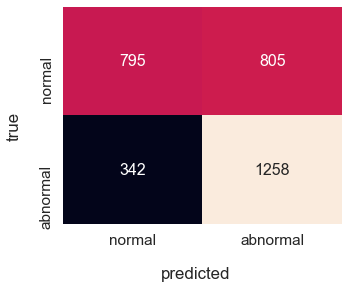

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn


classes = ["normal", "abnormal"]
true_classes_labels = [("normal" if (i == 0) else "abnormal") for i in true_classes]
pred_classes_labels = [("normal" if (i == 0) else "abnormal") for i in pred_classes]
cm = confusion_matrix(true_classes_labels, pred_classes_labels, labels = classes)
df_cm = pd.DataFrame(cm, classes, classes)
fig = plt.figure(figsize=(5,4))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cbar = False, annot=True, annot_kws={"size": 16}, fmt="d") # font size
plt.text(0.7,2.5,"predicted")
plt.text(-0.4,1.2,"true",rotation=90)
plt.show()